In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.cluster import KMeans
from tqdm import tqdm

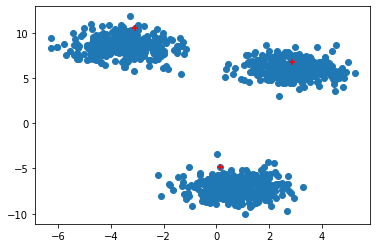

In [6]:
N=1000
k=3
d=2
X, y_true = make_blobs(n_samples=N, n_features=d, centers=k)
plt.scatter(X[:,0], X[:,1])
c = np.array([random.choice(X) for _ in range(k)])
plt.scatter(c[:,0], c[:,1], color="red", marker="+")

11.16736983800405
7.0188603972383286
0.035825534218191304
0.0


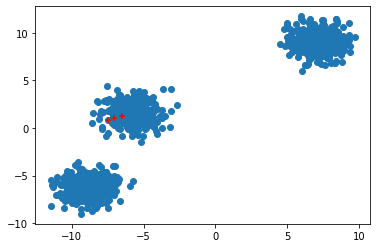

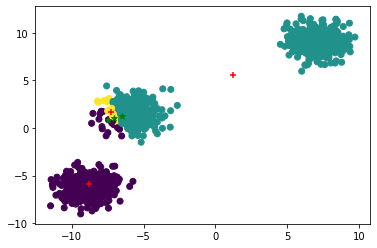

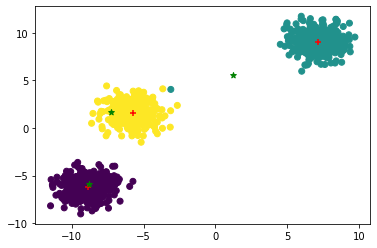

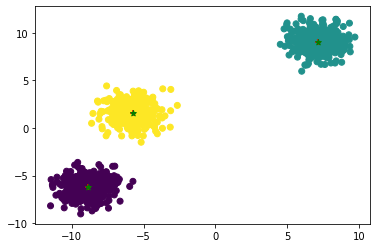

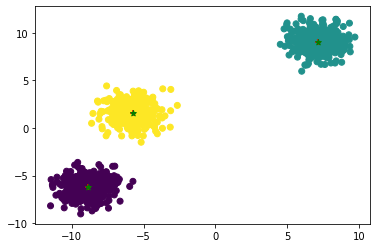

In [11]:
POPULATION_AXIS=0
FEATURE_AXIS=1
CLUSTER_AXIS=2

def k_means_round(X, centers):
    """Do one round of k-means: attribute each point to a center.
    
    Return the new centers, and the associated Y vector"""
    X_tensor = np.repeat(X.reshape(N, d, 1), k, axis=CLUSTER_AXIS)
    c_tensor = np.repeat(
        centers.reshape(k, d, 1).swapaxes(POPULATION_AXIS, CLUSTER_AXIS),
        N, 
        axis=POPULATION_AXIS)
    sqdist = np.square(X_tensor-c_tensor).sum(
        axis=FEATURE_AXIS).reshape(N, 1, k)
    y = np.argmin(sqdist, axis=CLUSTER_AXIS).reshape(N, 1, 1)
    new_centers = np.array([X[y.reshape(N) == i].mean(axis=POPULATION_AXIS) for i in range(k)])
    return y, new_centers, np.linalg.norm(centers-new_centers)


X, y_true = make_blobs(n_samples=N, n_features=d, centers=k)
c = np.array([random.choice(X) for _ in range(k)])
plt.figure()
plt.scatter(X[:,0], X[:,1])
plt.scatter(c[:,0], c[:,1], color="red", marker="+")
while True:
    plt.figure()
    old_c = c.copy()
    y, c, dist = k_means_round(X, c)
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.scatter(c[:,0], c[:,1], color="red", marker="+")
    plt.scatter(old_c[:,0], old_c[:,1], color="green", marker="*")
    print(dist)
    if dist == 0:
        break
    
    
y = k_means_round(X, c)



In [4]:
def full_naive(X, centers):
    X_tensor = np.repeat(X.reshape(N, d, 1), k, axis=CLUSTER_AXIS)
    c_tensor = np.repeat(
        c.reshape(k, d, 1).swapaxes(POPULATION_AXIS, CLUSTER_AXIS),
        N, 
        axis=POPULATION_AXIS)
    return X_tensor-c_tensor

X_tensor = np.repeat(X.reshape(N, d, 1), k, axis=CLUSTER_AXIS)

def x_out(X, centers):
    c_tensor = np.repeat(
        c.reshape(k, d, 1).swapaxes(POPULATION_AXIS, CLUSTER_AXIS),
        N, 
        axis=POPULATION_AXIS)
    return X_tensor-c_tensor


def x_out_in_place(X, centers):
    c_tensor = np.repeat(
        c.reshape(k, d, 1).swapaxes(POPULATION_AXIS, CLUSTER_AXIS),
        N, 
        axis=POPULATION_AXIS)
    np.subtract(X_tensor, c_tensor, out=c_tensor)
    return c_tensor

In [5]:
%timeit full_naive(X, c)

80.4 µs ± 1.97 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [6]:
%timeit x_out(X, c)

29.4 µs ± 1.22 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
%timeit x_out_in_place(X, c)

25.7 µs ± 1.59 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [36]:
POPULATION_AXIS=0
FEATURE_AXIS=1
CLUSTER_AXIS=2

N=100000
k=4
d=2

X, y_true = make_blobs(n_samples=N, n_features=d, centers=k)


def k_means_optimized_round(X_tensor, centers):
    """Do one round of k-means: attribute each point to a center.
    
    Return the new centers, and the associated Y vector"""
    k,d = centers.shape
    N = X_tensor.shape[0]
    c_tensor = np.repeat(
        centers.reshape(k, d, 1).swapaxes(POPULATION_AXIS, CLUSTER_AXIS),
        N, 
        axis=POPULATION_AXIS)
    sqdist = np.square(X_tensor-c_tensor).sum(
        axis=FEATURE_AXIS).reshape(N, 1, k)
    y = np.argmin(sqdist, axis=CLUSTER_AXIS).reshape(N, 1, 1)
    new_centers = np.array([X[y.reshape(N) == i].mean(axis=POPULATION_AXIS) for i in range(k)])
    return y, new_centers, np.linalg.norm(centers-new_centers)

def k_means(X, k):
    N, d = X.shape
    X_tensor = np.repeat(X.reshape(N, d, 1), k, axis=CLUSTER_AXIS)
    c = np.array([random.choice(X) for _ in range(k)])
    while True:
        old_c = c.copy()
        y, c, dist = k_means_optimized_round(X_tensor, c)
        if dist == 0 or dist != dist:
            return y

In [34]:
%timeit k_means(X)

720 ms ± 69.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
kk = KMeans(n_clusters=3, n_init=1)

In [22]:
%timeit kk.fit(X)

107 ms ± 5.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
duration = []
for N in tqdm(np.geomspace(100, 1000000, 5)):
    N = int(N)
    for k in tqdm([3, 10]):
        X, y_true = make_blobs(n_samples=N, n_features=d, centers=k)
        r = %timeit -o k_means(X, k)
        duration += [{"impl": "scikit", "n":N, "k":k, "nkd":N*k*d, "t": min(r.all_runs) / r.loops}]
        r = %timeit -o KMeans(n_clusters=k, n_init=1).fit(X)
        duration += [{"impl": "own", "n":N, "k":k, "nkd":N*k*d, "t": min(r.all_runs) / r.loops}]
      
duration
        
        
    

  0%|                                                                                      | 0/2 [00:00<?, ?it/s]/tmp/ipykernel_6227/2783185085.py:25: RuntimeWarning: Mean of empty slice.
  new_centers = np.array([X[y.reshape(N) == i].mean(axis=POPULATION_AXIS) for i in range(k)])
/gnu/store/sf0j1snh0n2g622k8fas7997apm7m7vq-python-numpy-1.23.2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


582 µs ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)



 50%|███████████████████████████████████████                                       | 1/2 [00:19<00:19, 19.66s/it]

1.83 ms ± 54 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


/tmp/ipykernel_6227/2783185085.py:25: RuntimeWarning: Mean of empty slice.
  new_centers = np.array([X[y.reshape(N) == i].mean(axis=POPULATION_AXIS) for i in range(k)])
/gnu/store/sf0j1snh0n2g622k8fas7997apm7m7vq-python-numpy-1.23.2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


1.57 ms ± 50.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)



 20%|███████████████▌                                                              | 1/5 [00:35<02:23, 35.79s/it]

4.05 ms ± 307 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)



  0%|                                                                                      | 0/2 [00:00<?, ?it/s]/tmp/ipykernel_6227/2783185085.py:25: RuntimeWarning: Mean of empty slice.
  new_centers = np.array([X[y.reshape(N) == i].mean(axis=POPULATION_AXIS) for i in range(k)])
/gnu/store/sf0j1snh0n2g622k8fas7997apm7m7vq-python-numpy-1.23.2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


5.13 ms ± 310 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)



 50%|███████████████████████████████████████                                       | 1/2 [00:06<00:06,  6.59s/it]

3 ms ± 500 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


/tmp/ipykernel_6227/2783185085.py:25: RuntimeWarning: Mean of empty slice.
  new_centers = np.array([X[y.reshape(N) == i].mean(axis=POPULATION_AXIS) for i in range(k)])
/gnu/store/sf0j1snh0n2g622k8fas7997apm7m7vq-python-numpy-1.23.2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


9.84 ms ± 604 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)



 40%|███████████████████████████████▏                                              | 2/5 [00:55<01:18, 26.13s/it]

5.78 ms ± 282 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)



  0%|                                                                                      | 0/2 [00:00<?, ?it/s]

70 ms ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)



 50%|███████████████████████████████████████                                       | 1/2 [00:09<00:09,  9.53s/it]

49 ms ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
The slowest run took 5.03 times longer than the fastest. This could mean that an intermediate result is being cached.
189 ms ± 108 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



 60%|██████████████████████████████████████████████▊                               | 3/5 [01:11<00:43, 21.64s/it]

56.7 ms ± 5.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)



  0%|                                                                                      | 0/2 [00:00<?, ?it/s]

The slowest run took 4.55 times longer than the fastest. This could mean that an intermediate result is being cached.
724 ms ± 472 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



 50%|███████████████████████████████████████                                       | 1/2 [00:16<00:16, 16.54s/it]

139 ms ± 5.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
The slowest run took 7.33 times longer than the fastest. This could mean that an intermediate result is being cached.
5.85 s ± 5.04 s per loop (mean ± std. dev. of 7 runs, 1 loop each)



 80%|██████████████████████████████████████████████████████████████▍               | 4/5 [02:15<00:38, 38.55s/it]

230 ms ± 11.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



 80%|██████████████████████████████████████████████████████████████▍               | 4/5 [06:22<01:35, 95.61s/it]


KeyboardInterrupt: 

In [41]:
import seaborn as sns
sns.lineplot(data=duration, x="nkd", y="t", hue="impl")

TypeError: Data source must be a DataFrame or Mapping, not <class 'list'>.

In [42]:
duration

[{'impl': 'scikit', 'n': 100, 'k': 3, 'nkd': 600, 't': 0.0005637648520005313},
 {'impl': 'own', 'n': 100, 'k': 3, 'nkd': 600, 't': 0.0017721661550003773},
 {'impl': 'scikit',
  'n': 100,
  'k': 10,
  'nkd': 2000,
  't': 0.0015090101049991063},
 {'impl': 'own', 'n': 100, 'k': 10, 'nkd': 2000, 't': 0.0038425147899943113},
 {'impl': 'scikit', 'n': 1000, 'k': 3, 'nkd': 6000, 't': 0.004706469119992107},
 {'impl': 'own', 'n': 1000, 'k': 3, 'nkd': 6000, 't': 0.002673090959997353},
 {'impl': 'scikit',
  'n': 1000,
  'k': 10,
  'nkd': 20000,
  't': 0.008812031369998294},
 {'impl': 'own', 'n': 1000, 'k': 10, 'nkd': 20000, 't': 0.0054330125999877054},
 {'impl': 'scikit',
  'n': 10000,
  'k': 3,
  'nkd': 60000,
  't': 0.05424256919995969},
 {'impl': 'own', 'n': 10000, 'k': 3, 'nkd': 60000, 't': 0.024739009799850463},
 {'impl': 'scikit',
  'n': 10000,
  'k': 10,
  'nkd': 200000,
  't': 0.08676067399937892},
 {'impl': 'own',
  'n': 10000,
  'k': 10,
  'nkd': 200000,
  't': 0.046043451399964394},
 {'